实验内容
人口统计分析
国家和地区分布：统计用户所在国家和地区的分布，识别主要的开发者集中地。
城市级别分布：分析主要城市的开发者密度，发现技术热点区域。
时区分布:了解用户的时区分布，分析不同地区用户的协作时间模式。
协作行为分析
提交频率：统计每个用户的提交次数，识别高活跃用户和低活跃用户。
其他维度有趣的洞察（至少2个）
提交内容
数据分析代码。
最终的数据洞察报告（PDF格式）。


数据加载成功！
   user_id    name     location  total_influence        country   event_type  \
0   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
1   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
2   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
3   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   
4   663432  bdraco  Houston, TX      1776.967163  United States  CreateEvent   

  event_action                 event_time  
0        added  2024-11-26 20:28:37+08:00  
1        added  2024-11-26 20:42:57+08:00  
2        added  2024-11-27 04:10:46+08:00  
3        added  2024-11-27 17:43:50+08:00  
4        added  2024-11-27 19:56:34+08:00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294776 entries, 0 to 1294775
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   user_id          1294776 non-null 

C:\Users\大头\AppData\Local\Temp\ipykernel_904\81258415.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')


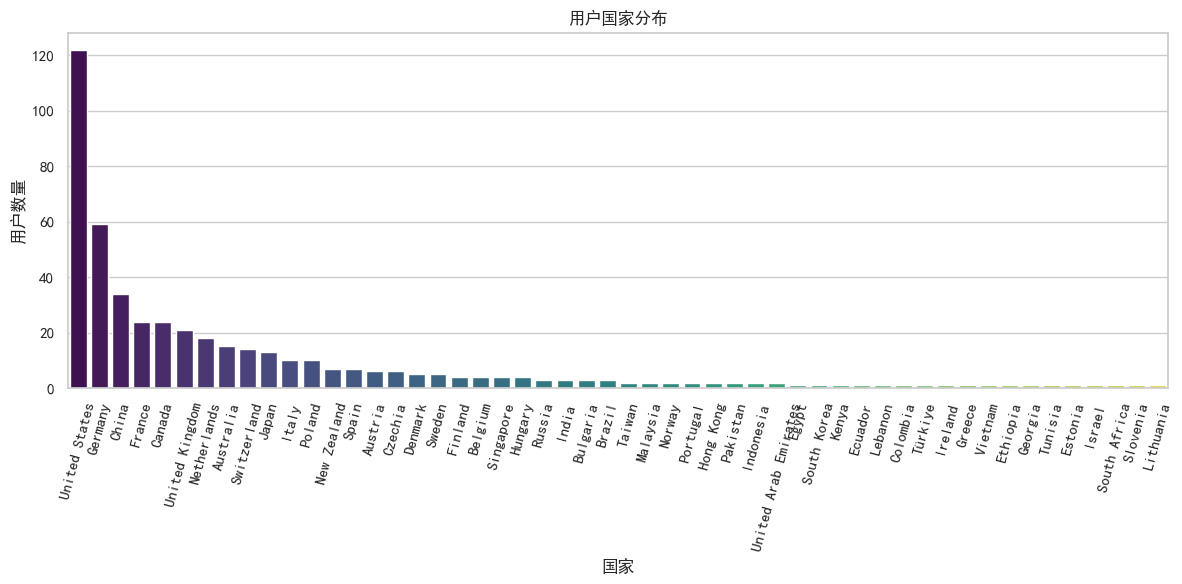

C:\Users\大头\AppData\Local\Temp\ipykernel_904\81258415.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.index, y=city_counts.values, palette='magma')


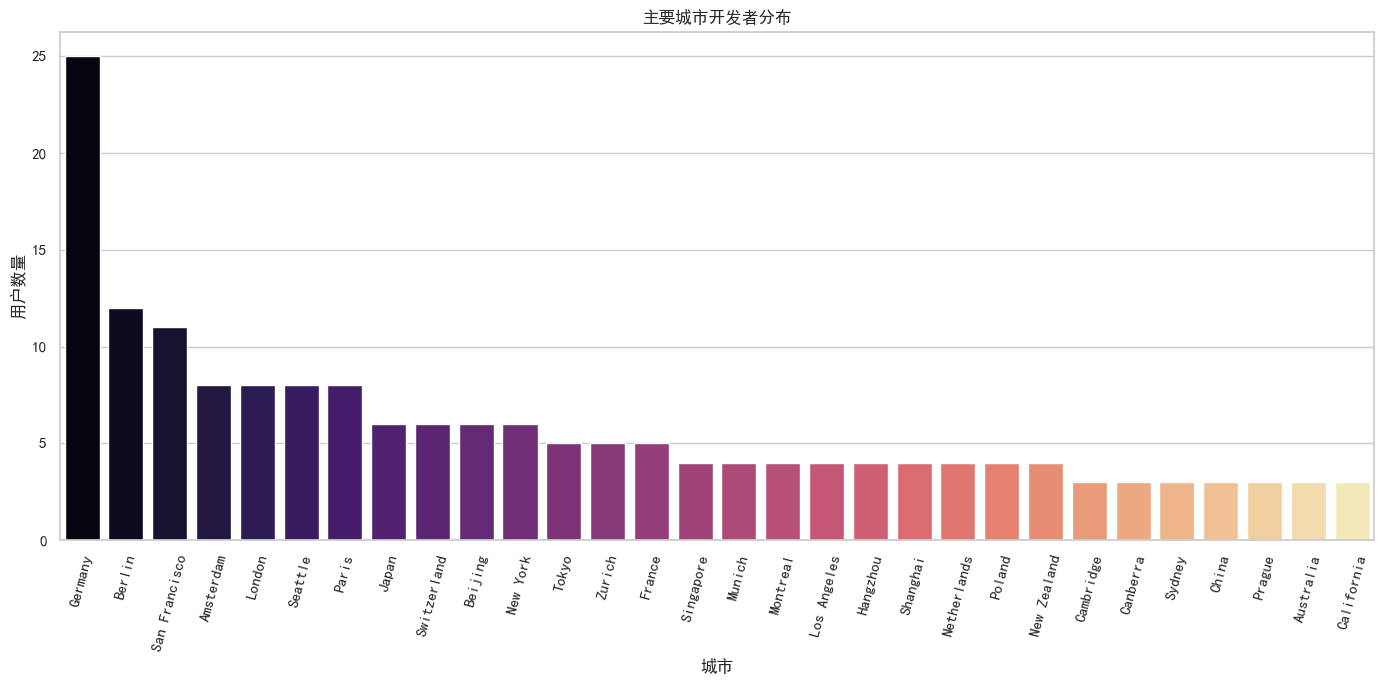

Timezone
Europe/Berlin          59
America/Los_Angeles    54
Asia/Shanghai          34
America/New_York       33
Europe/Paris           28
                       ..
Europe/Tallinn          1
Asia/Jerusalem          1
Africa/Johannesburg     1
Europe/Ljubljana        1
Europe/Vilnius          1
Name: count, Length: 67, dtype: int64


C:\Users\大头\AppData\Local\Temp\ipykernel_904\81258415.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=timezone_counts.index, y=timezone_counts.values, palette='coolwarm')


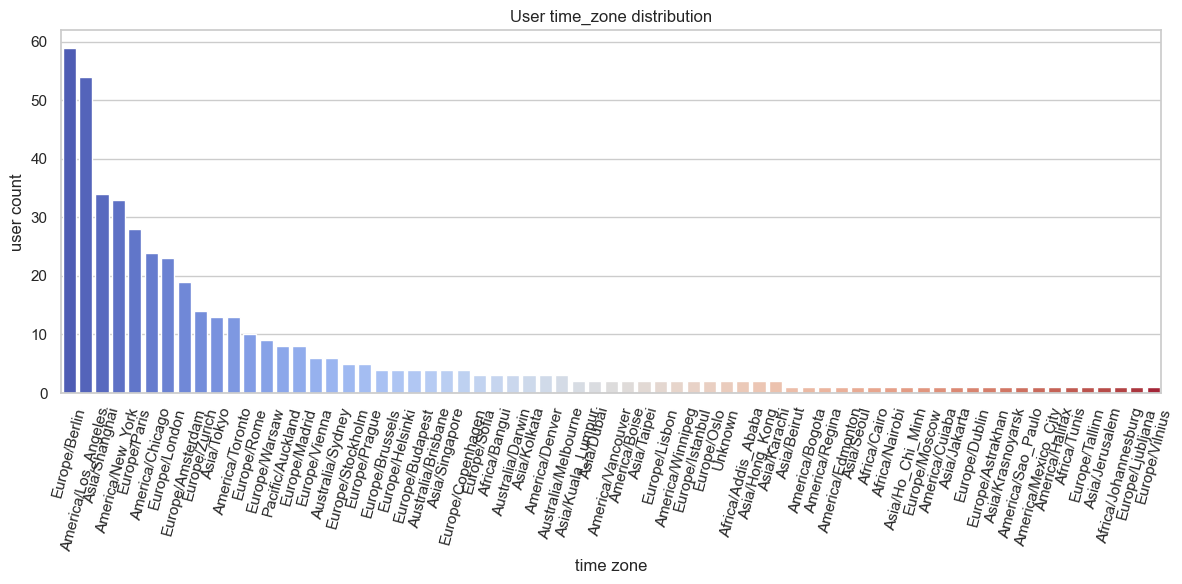

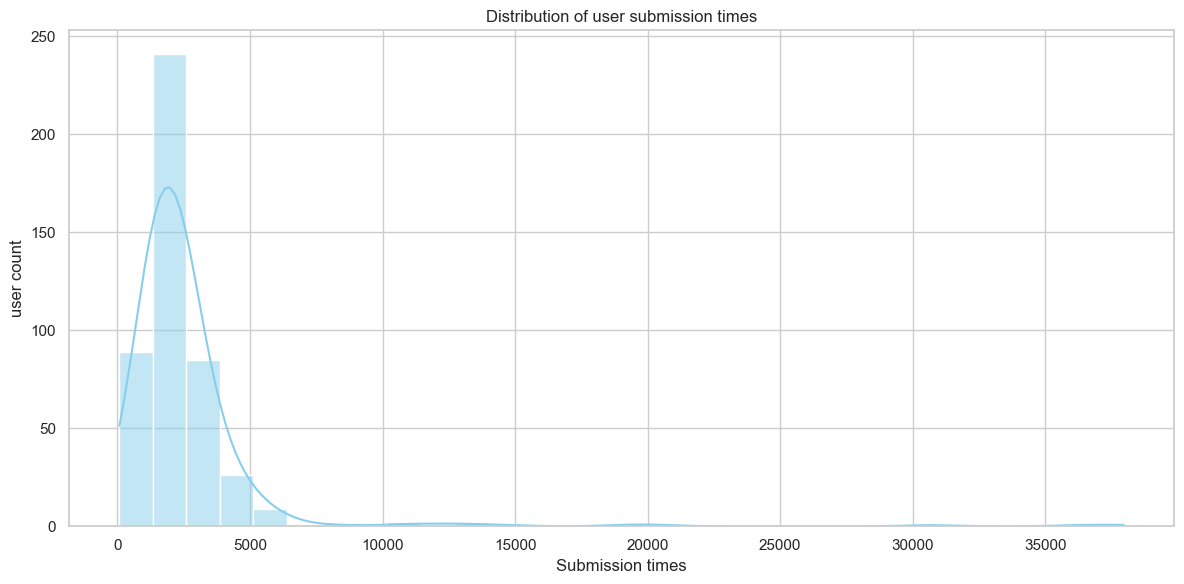

高活跃用户数量（提交次数 >= 2524.7）：139
低活跃用户数量（提交次数 <= 1596.5）：139


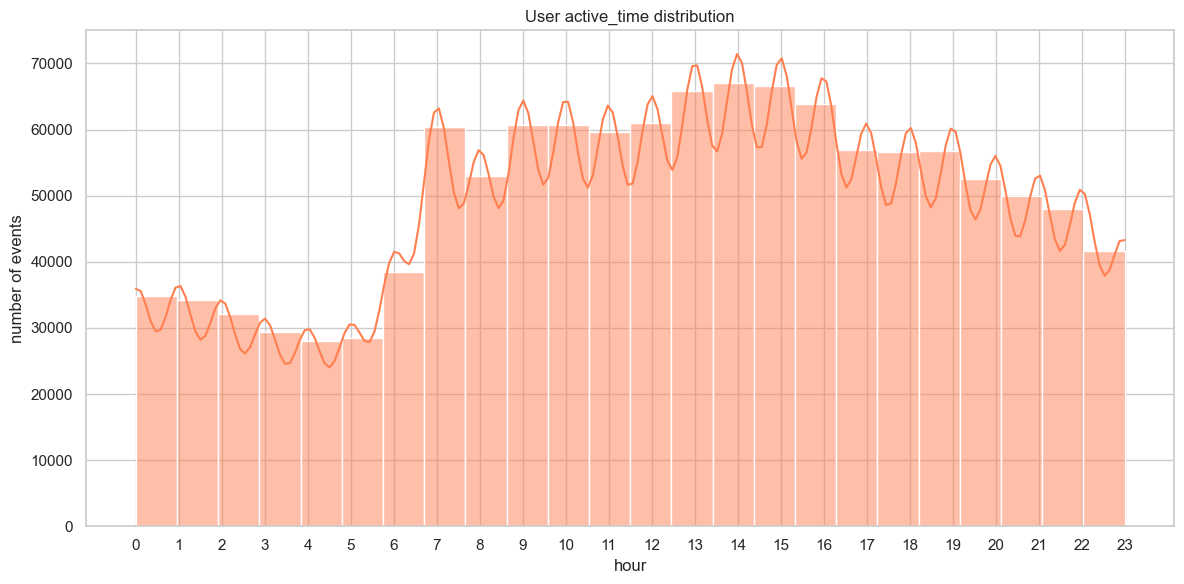

C:\Users\大头\AppData\Local\Temp\ipykernel_904\81258415.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_type_counts.index, y=event_type_counts.values, palette='Set2')


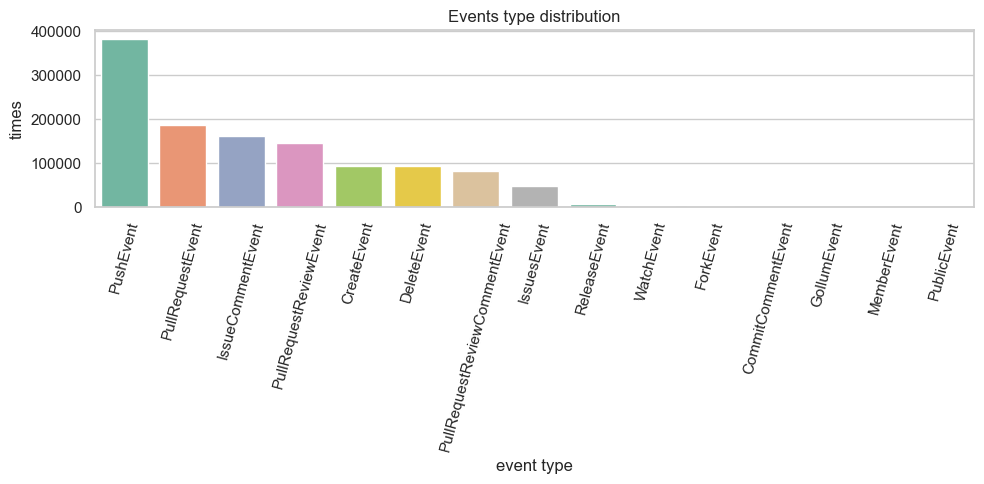

C:\Users\大头\AppData\Local\Temp\ipykernel_904\81258415.py:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_action_counts.index, y=event_action_counts.values, palette='Set3')


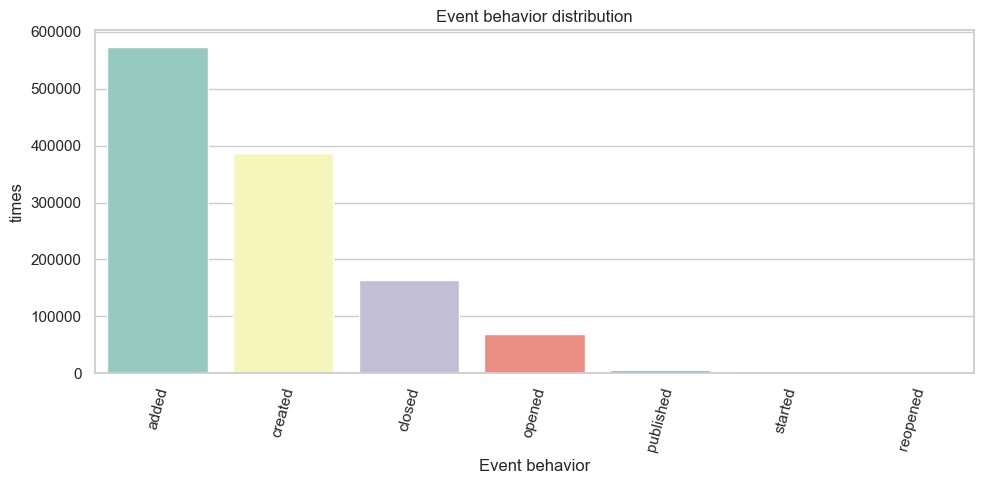

PDF report generated: User_Data_Insights_Report.pdf


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timezonefinder import TimezoneFinder
from geopy.geocoders import Nominatim
from fpdf import FPDF
import time
import json
import os
import logging

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    

logging.basicConfig(filename='geocoding_errors.log', level=logging.ERROR,
                    format='%(asctime)s %(levelname)s:%(message)s')

data_file_path = r"C:\Users\大头\Desktop\users_combined_info_500.csv"

try:
    data = pd.read_csv(data_file_path)
    print("数据加载成功！")
except FileNotFoundError:
    print(f"未找到文件：{data_file_path}")
    exit()
except Exception as e:
    print(f"读取文件时发生错误：{e}")
    exit()

# 数据预览
print(data.head())
print(data.info())

# 数据清洗
data_clean = data.dropna(subset=['user_id', 'location', 'country', 'event_time'])
print(f"清洗后数据量：{data_clean.shape}")

# 选择前500个唯一用户
user_info = data_clean.drop_duplicates(subset=['user_id']).head(500).copy()
collab_logs = data_clean[data_clean['user_id'].isin(user_info['user_id'])].copy()
print(f"筛选后用户信息数据量：{user_info.shape}")
print(f"筛选后协作日志数据量：{collab_logs.shape}")

# 定义清洗城市名称的函数
def clean_city_name(city):
    # 移除任何非标准字符或模式
    if '⇄' in city:
        return city.split('⇄')[0].strip()
    return city.strip()

# 提取并清洗城市信息
user_info['City'] = user_info['location'].apply(lambda x: x.split(',')[0].strip())
user_info['City'] = user_info['City'].apply(clean_city_name)

# 提取唯一城市列表
unique_cities = user_info['City'].unique()
print(f"唯一城市数量：{len(unique_cities)}")

# 检查是否已有缓存
cache_file = 'city_timezone_cache.json'
if os.path.exists(cache_file):
    with open(cache_file, 'r', encoding='utf-8') as f:
        city_timezone_map = json.load(f)
    print("加载了缓存的城市时区映射。")
else:
    city_timezone_map = {}
    print("未找到缓存，将开始地理编码请求。")

# 初始化地理编码器
# 设置合规的 User-Agent
geolocator = Nominatim(user_agent="github_data_analysis_app (2957307229@qq.com)")
tf = TimezoneFinder()

# 遍历唯一城市并获取时区
for city in unique_cities:
    if city in city_timezone_map:
        continue  # 已经有缓存，跳过
    try:
        location = geolocator.geocode(city, timeout=10)
        if location:
            timezone = tf.timezone_at(lng=location.longitude, lat=location.latitude)
            if timezone:
                city_timezone_map[city] = timezone
                print(f"{city} 的时区：{timezone}")
            else:
                city_timezone_map[city] = 'Unknown'
                print(f"无法确定 {city} 的时区。")
        else:
            city_timezone_map[city] = 'Unknown'
            print(f"无法找到城市 {city} 的地理位置。")
    except Exception as e:
        city_timezone_map[city] = 'Unknown'
        logging.error(f"获取 {city} 时区时发生错误：{e}")
        print(f"获取 {city} 时区时发生错误：{e}")
    time.sleep(1)  # 遵守Nominatim的使用政策，避免请求过于频繁

# 保存缓存
with open(cache_file, 'w', encoding='utf-8') as f:
    json.dump(city_timezone_map, f, ensure_ascii=False, indent=4)
print("已保存城市时区映射到缓存文件。")

# 将时区信息映射到用户信息中
user_info['Timezone'] = user_info['City'].map(city_timezone_map)

# 处理未映射的时区
user_info['Timezone'] = user_info['Timezone'].fillna('Unknown')

# 国家分布
country_counts = user_info['country'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')
plt.xticks(rotation=75)
plt.title('用户国家分布')
plt.xlabel('国家')
plt.ylabel('用户数量')
plt.tight_layout()
plt.savefig('output_images/country_distribution.png')  # 保存图片
plt.show()

# 城市分布
city_counts = user_info['City'].value_counts().head(30)
plt.figure(figsize=(14,7))
sns.barplot(x=city_counts.index, y=city_counts.values, palette='magma')
plt.xticks(rotation=75)
plt.title('主要城市开发者分布')
plt.xlabel('城市')
plt.ylabel('用户数量')
plt.tight_layout()
plt.savefig('output_images/city_distribution.png')  # 保存图片
plt.show()

# 查看时区分布
timezone_counts = user_info['Timezone'].value_counts()
print(timezone_counts)

# 可视化时区分布
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=timezone_counts.index, y=timezone_counts.values, palette='coolwarm')
plt.xticks(rotation=75)
plt.title('User time_zone distribution')
plt.xlabel('time zone')
plt.ylabel('user count')
plt.tight_layout()
plt.savefig('output_images/timezone_distribution.png')  # 保存图片
plt.show()

# 提交频率分析
submission_counts = collab_logs['user_id'].value_counts()
plt.figure(figsize=(12,6))
sns.histplot(submission_counts, bins=30, kde=True, color='skyblue')
plt.title('Distribution of user submission times')
plt.xlabel('Submission times')
plt.ylabel('user count')
plt.tight_layout()
plt.savefig('output_images/submission_frequency.png')  # 保存图片
plt.show()

# 定义高活跃和低活跃的阈值
high_active_threshold = submission_counts.quantile(0.7)
low_active_threshold = submission_counts.quantile(0.3)
high_active_users = submission_counts[submission_counts >= high_active_threshold]
low_active_users = submission_counts[submission_counts <= low_active_threshold]
print(f'高活跃用户数量（提交次数 >= {high_active_threshold}）：{high_active_users.count()}')
print(f'低活跃用户数量（提交次数 <= {low_active_threshold}）：{low_active_users.count()}')

# 活跃时间段分析
collab_logs['event_time'] = pd.to_datetime(collab_logs['event_time'])
merged_data = collab_logs.merge(user_info[['user_id', 'country']], on='user_id', how='left')
merged_data['hour'] = merged_data['event_time'].dt.hour
plt.figure(figsize=(12,6))
sns.histplot(merged_data['hour'], bins=24, kde=True, color='coral')
plt.title('User active_time distribution')
plt.xlabel('hour')
plt.ylabel('number of events')
plt.xticks(range(0,24))
plt.tight_layout()
plt.savefig('output_images/active_time_distribution.png')  
plt.show()

# 事件类型和行为分析
event_type_counts = collab_logs['event_type'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=event_type_counts.index, y=event_type_counts.values, palette='Set2')
plt.xticks(rotation=75)
plt.title('Events type distribution')
plt.xlabel('event type')
plt.ylabel('times')
plt.tight_layout()
plt.savefig('output_images/event_type_distribution.png')  
plt.show()

event_action_counts = collab_logs['event_action'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=event_action_counts.index, y=event_action_counts.values, palette='Set3')
plt.xticks(rotation=75)
plt.title('Event behavior distribution')
plt.xlabel('Event behavior')
plt.ylabel('times')
plt.tight_layout()
plt.savefig('output_images/event_behavior_distribution.png')
plt.show()
class PDFReport(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'User Data Insights Report', align='C', ln=True)
        self.ln(10)

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, align='L', ln=True)
        self.ln(5)

    def chapter_body(self, text):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, text)
        self.ln(5)

    def add_image(self, image_path, caption):
        self.set_font('Arial', 'I', 10)
        self.cell(0, 10, caption, align='C', ln=True)
        self.image(image_path, x=10, w=180)
        self.ln(10)


# 初始化 PDF 报告
pdf = PDFReport()
pdf.set_auto_page_break(auto=True, margin=15)

# 设置标题页
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.cell(0, 10, 'User Data Insights Report', align='C', ln=True)
pdf.ln(10)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 10, "This report presents an analysis of user collaboration behavior, including geographical distribution, timezone patterns, activity levels, and event types.")

# 添加章节：国家分布
pdf.add_page()
pdf.chapter_title("1. Country Distribution")
pdf.chapter_body("The following visualization represents the distribution of users across different countries.")
pdf.add_image('output_images/country_distribution.png', "Country Distribution")

# 添加章节：城市分布
pdf.chapter_title("2. City Distribution")
pdf.chapter_body("The following visualization represents the distribution of users across major cities.")
pdf.add_image('output_images/city_distribution.png', "City Distribution")

# 添加章节：时区分布
pdf.chapter_title("3. Timezone Distribution")
pdf.chapter_body("The visualization below shows the distribution of users across different time zones.")
pdf.add_image('output_images/timezone_distribution.png', "Timezone Distribution")

# 添加章节：提交频率分析
pdf.add_page()
pdf.chapter_title("4. Submission Frequency Analysis")
pdf.chapter_body("The histogram below represents the distribution of user submission counts.")
pdf.add_image('output_images/submission_frequency.png', "Submission Frequency Distribution")

# 添加章节：活跃时间段分析
pdf.chapter_title("5. Active Time Period Analysis")
pdf.chapter_body("The following visualization represents the hourly distribution of user activity.")
pdf.add_image('output_images/active_time_distribution.png', "Active Time Distribution")

# 添加章节：事件类型和行为分析
pdf.add_page()
pdf.chapter_title("6. Event Type and Behavior Analysis")
pdf.chapter_body("The following visualizations represent the distribution of event types and behaviors.")
pdf.add_image('output_images/event_type_distribution.png', "Event Type Distribution")
pdf.add_image('output_images/event_behavior_distribution.png', "Event Behavior Distribution")

# 保存 PDF
output_pdf_path = "User_Data_Insights_Report.pdf"
pdf.output(output_pdf_path)
print(f"PDF report generated: {output_pdf_path}")
